In [1]:
import numpy as np
import matplotlib.pyplot as plt
from neural_network.trainutils import *
import os

np.random.seed(0)

In [2]:
current_dir = os.getcwd()
face_dir = os.path.join(current_dir, "cmu+face+images", "faces")
iterations = 1000
k = 64
dataset = NMFDataset(face_dir)
dataset.data = dataset.data.astype(np.float64) / 255.0
train_dataset, _, test_dataset = train_test_split(dataset, dataset_type="nmf")

train_dataset.nmf(k)

KeyboardInterrupt: 

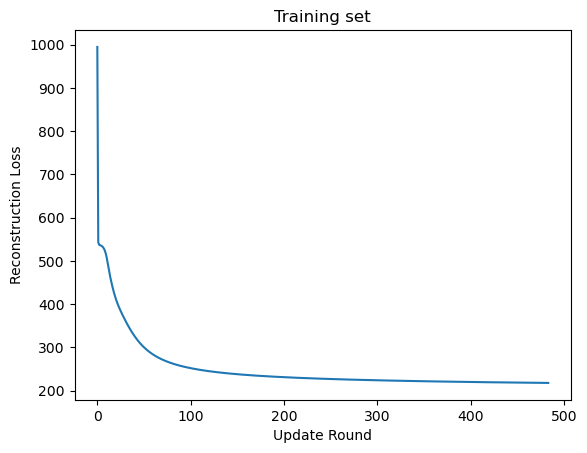

In [28]:
plt.figure()
plt.plot(train_dataset.nnmf_loss)
plt.xlabel("Update Round")
plt.ylabel("Reconstruction Loss")
plt.title("Training set")

plt.savefig("plots/nmf_fitting_loss.pdf", format="pdf", bbox_inches="tight")

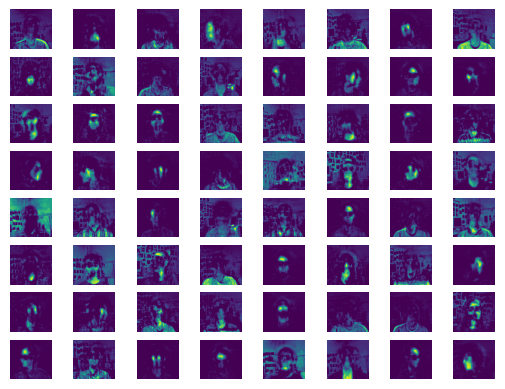

In [6]:
#Plot NMF-faces
plt.figure()
plot_dim = 8
for i in range(plot_dim):
    for j in range(plot_dim):
        plt.subplot(plot_dim, plot_dim, plot_dim*i + j + 1)
        plt.imshow(train_dataset.H[plot_dim*i + j,:].reshape((120, 128)))
        plt.axis("off")

In [5]:
#save
import pickle

with open('nmfdataset_trained_on_trainingonly.pickle', 'wb') as handle:
    pickle.dump(dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [1]:
#load
import pickle

with open('nmfdataset.pickle', 'rb') as handle:
    dataset = pickle.load(handle)

In [8]:
test_dataset.data.shape

(125, 120, 128)

In [9]:
np.mean(test_dataset.data)

0.26883561070261447

In [25]:
def update_W_only(W, H, test_dataset):

    W_numerator = np.matmul(test_dataset, H.T)
    W_denominator = np.matmul(np.matmul(W, H), H.T)
    W_alpha = np.divide(W_numerator, W_denominator)
    
    W = W*W_alpha

    return W

In [26]:
convergence = 0.9999
test_dataset_init = test_dataset.data.reshape(test_dataset.data.shape[0], -1)
nnmf_scaler = np.sqrt(np.mean(test_dataset_init)/test_dataset_init.shape[0])
W_test = abs(np.random.standard_normal((test_dataset.data.shape[0], k)))*nnmf_scaler
test_nnmf_loss = []

H_train = train_dataset.H

test_nnmf_loss.append(np.linalg.norm(test_dataset_init - np.matmul(W_test, H_train), "fro"))
W_test = update_W_only(W_test, H_train, test_dataset_init)
test_nnmf_loss.append(np.linalg.norm(test_dataset_init - np.matmul(W_test, H_train), "fro"))

while test_nnmf_loss[-1]/test_nnmf_loss[-2] < convergence:
    W_test = update_W_only(W_test, H_train, test_dataset_init)
    test_nnmf_loss.append(np.linalg.norm(test_dataset_init - np.matmul(W_test, H_train), "fro"))

test_embeddings = W_test.reshape(-1, 64, 1)

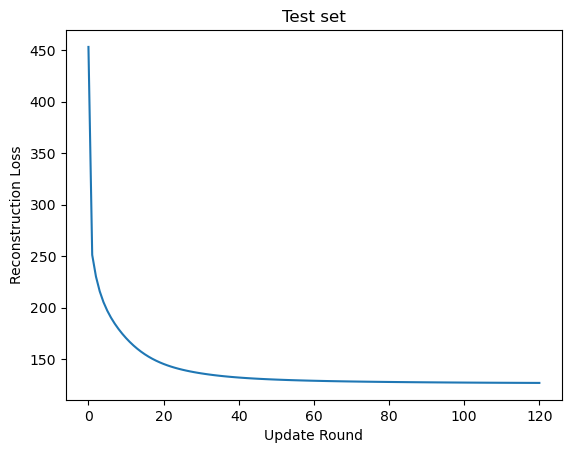

In [29]:
plt.figure()
plt.plot(test_nnmf_loss)
plt.xlabel("Update Round")
plt.ylabel("Reconstruction Loss")
plt.title("Test set")

plt.savefig("plots/nmf_testset_loss.pdf", format="pdf", bbox_inches="tight")

In [31]:
print(W_test.shape)
print(train_dataset.W.shape)


(125, 64)
(499, 64)


In [170]:
import seaborn as sns
def mode1(x):
    values, counts = np.unique(x, return_counts=True)
    m = counts.argmax()
    return values[m], counts[m]

def KNN(train_embeddings, train_labels, test_embeddings, test_labels, k=3, speak=True):

    assert(k > 0)
    labels = {"left": 0, "right": 1, "straight" : 2, "up": 3}

    knn_confusion_matrix = np.zeros(shape=[len(labels)]*2)

    for data, label in zip(test_embeddings, test_labels):

        distances = np.linalg.norm(train_embeddings - data, axis=1)
        neighbors = np.sort(distances)[:k]
        print(neighbors)
        preds = []

        for neighbor in neighbors:
            
            pred_idx = np.where(distances == neighbor)
            print("pidx", pred_idx)
            try:
                preds.append(train_labels[pred_idx][0])
            except:
                preds.append(train_labels[pred_idx[0]])
        print(preds)
        prediction = mode1(preds)[0]
        
        knn_confusion_matrix[label, prediction] += 1

    knn_accuracy = knn_confusion_matrix.trace()/knn_confusion_matrix.sum()

    if speak:
        print(f"{k}-KNN accuracy: {knn_accuracy}")

        plt.figure()
        sns.heatmap(knn_confusion_matrix, annot=True, cbar=False, xticklabels=labels.keys(), yticklabels=labels.keys(), cmap="YlGnBu")
        plt.xlabel("Predicted")
        plt.ylabel("Ground truth")
        #plt.title(f"{k}-KNN confusion matrix")
        plt.savefig(f"plots/knn_confusion_{k}.pdf", format="pdf", bbox_inches="tight")
    
    return knn_accuracy, knn_confusion_matrix

4-KNN accuracy: 0.816


(0.816,
 array([[31.,  0.,  2.,  3.],
        [ 0., 30.,  0.,  3.],
        [ 1.,  0., 23.,  5.],
        [ 2.,  0.,  7., 18.]]))

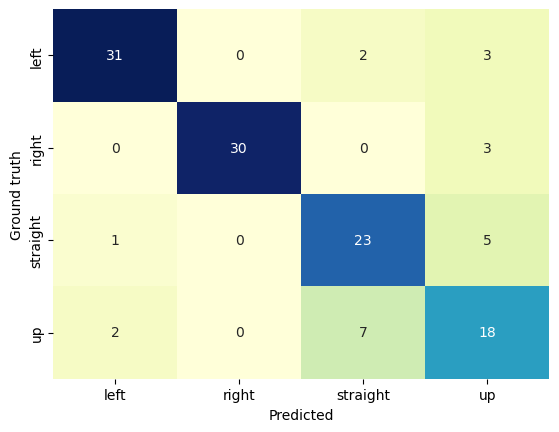

In [46]:
KNN(train_dataset.W, train_dataset.label, W_test, test_dataset.label, k=4)

In [51]:
train_dataset.data

array([[[2.66125535e-05],
        [1.44927674e-02],
        [7.22949323e-04],
        ...,
        [6.68052503e-05],
        [2.71158220e-01],
        [2.69773917e-02]],

       [[4.13686566e-01],
        [2.65576854e-10],
        [2.69560989e-02],
        ...,
        [1.73628980e-06],
        [2.99689921e-02],
        [1.25762496e-07]],

       [[8.51201177e-05],
        [8.86849505e-06],
        [5.56196866e-01],
        ...,
        [1.46299897e-11],
        [1.99245653e-01],
        [3.35247820e-10]],

       ...,

       [[1.54352685e-22],
        [9.21523196e-02],
        [2.31976889e-20],
        ...,
        [1.11078636e-14],
        [4.82516389e-01],
        [1.27265689e-06]],

       [[1.50144035e-04],
        [6.59093285e-01],
        [6.70686001e-05],
        ...,
        [2.87142848e-05],
        [4.72112541e-02],
        [8.81867017e-04]],

       [[7.79129083e-12],
        [1.30302693e-01],
        [3.15630971e-19],
        ...,
        [5.89785611e-19],
        [2.2031

In [162]:
def backward_feature_selection(dataset, k_fold=5, idx_amount=1):

    # model = create_model(dataset.data.shape[-2], 4)
    init_results = k_fold_cross_validation(k_fold, dataset)
    init_val_loss = sum(init_results)/len(init_results)
    remaining_indices = np.arange(dataset.data.shape[-2])

    prev_fold_loss = init_val_loss
    min_fold_loss, worst_idx = backward_feature_selection_step(dataset, remaining_indices)
    print(len(remaining_indices), "min:", min_fold_loss, "prev", prev_fold_loss, worst_idx)
    

    while (min_fold_loss < prev_fold_loss) and (len(remaining_indices) > idx_amount):
        
        remaining_indices = np.delete(remaining_indices, worst_idx)
        print(len(remaining_indices))
        
        prev_fold_loss = min_fold_loss

        min_fold_loss, worst_idx = backward_feature_selection_step(dataset, remaining_indices)
        print(len(remaining_indices), "min:", min_fold_loss, "prev", prev_fold_loss, worst_idx)
    
    return remaining_indices


def backward_feature_selection_step(dataset, remaining_indices, k_fold=5, idx_amount=1):
    
    np.random.shuffle(remaining_indices)
    cur_iter_remaining_indices = np.copy(remaining_indices)
    max_fold_loss, min_fold_loss = -np.inf, np.inf
    worst_idx = None
    print(int(np.ceil(len(cur_iter_remaining_indices)/idx_amount)))
    for idx in range(int(np.ceil(len(cur_iter_remaining_indices)/idx_amount))):
        # random_indices = np.random.choice(cur_iter_remaining_indices, idx_amount)
        random_indices = cur_iter_remaining_indices[idx*idx_amount:min((idx+1)*idx_amount, len(cur_iter_remaining_indices))]
        temp_array = np.copy(remaining_indices)
        dataset.selected_indices = temp_array[~np.isin(temp_array, random_indices)]
        fold_results = k_fold_cross_validation(k_fold, dataset)
        fold_val_loss = sum(fold_results)/len(fold_results)
        
        if fold_val_loss > max_fold_loss:
            max_fold_loss = fold_val_loss
            worst_idx = random_indices
        
        min_fold_loss = min(min_fold_loss, fold_val_loss)
        
    
    return min_fold_loss, worst_idx

def k_fold_cross_validation(k: int, dataset, seed: int = None, dataset_type="default", knn_k=1):
    results = []

    # shuffle once
    shuffle_order = np.random.permutation(np.arange(len(dataset)))
    dataset.data = dataset.data[shuffle_order].reshape(
        -1, dataset.data.shape[-2], dataset.data.shape[-1]
    )
    dataset.label = dataset.label[shuffle_order].reshape(dataset.label.shape[-1])
    
    for fold in range(k):
        train_dataset, validation_dataset, _ = train_test_split(dataset, ratios=((k - 1) / k, 1 / k, 0), mode="shift", shift=len(dataset) // k, dataset_type="nmf")
        train_dataset.selected_indices = remaining_features
        validation_dataset.selected_indices = remaining_features
        result = KNN(train_dataset.data, train_dataset.label, validation_dataset.data, validation_dataset.label, speak=False, k=knn_k)[0]
        results.append(result)
    
    return results

In [145]:
remaining_features = backward_feature_selection(train_dataset)

64
64 min: 0.22799999999999998 prev 0.278 [28]
63
63
63 min: 0.20799999999999996 prev 0.22799999999999998 [4]
62
62
62 min: 0.21000000000000002 prev 0.20799999999999996 [55]


In [173]:
train_dataset.selected_indices = remaining_features
best_result = -np.inf
for knn_k in range(1, len(remaining_features)+1):
    print(knn_k)
    fold_results = k_fold_cross_validation(5, dataset, knn_k=knn_k)
    fold_val_acc = sum(fold_results)/len(fold_results)
    print(fold_val_acc)

1
[[0.54942562 0.61623555 0.62995823 0.64106553 0.8236041  0.97754882
  1.00523046 1.1114517  1.24264851 1.28798308 1.29712663 1.43860649
  1.4455702  1.44906073 1.46003534 1.5241589  1.54397292 1.54762906
  1.56100599 1.56656237 1.59845177 1.60114818 1.60288571 1.61256123
  1.64721755 1.6554455  1.6618292  1.66503727 1.70323888 1.70666198
  1.7117546  1.71811705 1.72491078 1.73243256 1.73994834 1.75492277
  1.75998497 1.77762591 1.77952384 1.79124703 1.79179213 1.80230106
  1.80451397 1.81633834 1.81933314 1.8276866  1.82792218 1.84340841
  1.84661333 1.86958908 1.86985639 1.8873341  1.88750928 1.88833201
  1.89529456 1.8973666  1.92230078 1.9329117  1.93333333 1.95410628
  1.97961934 2.013293   2.01532384 2.03815206 2.05098789 2.05257315
  2.05357688 2.07977019 2.08308026 2.08421319 2.10105336 2.10132782
  2.10157298 2.1187724  2.12813669 2.19867843 2.22507813 2.24784916
  2.30000251 2.31190357 2.34422569 2.352075   2.3739066  2.41156384
  2.41158934 2.43492151 2.44424486 2.44490856 

ValueError: attempt to get argmax of an empty sequence